# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import random
import csv
from scipy.stats import norm
from google.cloud import storage
from google.colab import auth
from google.cloud import bigquery

# Setup tickers array

In [ ]:
tickers = ['ULVR.L','VOD.L', 'STAN.L', 'HSBA.L', 'CCH.L', 'BARC.L']
start_date = '2013-11-20 00:00:00.000000'
end_date = '2023-11-24 23:59:59.999999'

# Use BigQuery SQL to populate dataframe

In [ ]:
close_df = pd.DataFrame()

for ticker in tickers:
  sql = f'''WITH subquery AS (
    SELECT *,
          ROW_NUMBER() OVER (PARTITION BY RIC,  DATE(Date_Time) ORDER BY Date_Time DESC) AS row_num
    FROM `dbd-sdlc-prod.LSE_NORMALISED.LSE_NORMALISED`
    WHERE RIC IN ('{ticker}')
    AND (Date_Time BETWEEN TIMESTAMP('{start_date}') AND TIMESTAMP('{end_date}'))
    AND Type="Trade"
    AND Volume >0
    AND Price >0
    AND RIGHT(REGEXP_EXTRACT(Qualifiers, r";(.*)\[MMT_CLASS\]"),14) LIKE "12%"
  )
  SELECT FORMAT_DATETIME('%Y-%m-%d', Date_Time) AS Date, RIC, Price
  FROM subquery
  WHERE row_num = 1
  ORDER BY Date_Time ASC;
  '''
  #print(sql)
  data = pd.read_gbq(sql)
  data.set_index('Date', inplace=True)
  close_df[ticker] = data['Price'].astype(float)
  print(close_df[ticker])


print(close_df)

Date
2015-11-09    2814.0
2015-11-10    2809.0
2015-11-11    2846.0
2015-11-12    2803.0
2015-11-13    2754.0
               ...  
2023-11-20    3777.5
2023-11-21    3797.5
2023-11-22    3821.5
2023-11-23    3795.0
2023-11-24    3800.5
Name: ULVR.L, Length: 2033, dtype: float64
Date
2015-11-09    214.45
2015-11-10    222.80
2015-11-11    224.45
2015-11-12    221.60
2015-11-13    220.40
               ...  
2023-11-20     74.65
2023-11-21     74.49
2023-11-22     75.10
2023-11-23     71.00
2023-11-24     71.78
Name: VOD.L, Length: 2033, dtype: float64
Date
2015-11-09    611.7
2015-11-10    599.6
2015-11-11    594.5
2015-11-12    582.1
2015-11-13    574.8
              ...  
2023-11-20    665.0
2023-11-21    663.4
2023-11-22    658.4
2023-11-23    663.6
2023-11-24    667.2
Name: STAN.L, Length: 2033, dtype: float64
Date
2015-11-09    527.6
2015-11-10    523.4
2015-11-11    523.6
2015-11-12    521.0
2015-11-13    513.2
              ...  
2023-11-20    616.6
2023-11-21    613.4
2023-11-22

# Calculate Daily Log Returns
Calculate the daily log returns for each stock in our portfolio and drop any missing values.

In [ ]:
### Calculate the daily log returns and drop any NAs
log_returns = np.log(close_df/close_df.shift(1))
log_returns  = log_returns.dropna()

print(log_returns)

log_returns

              ULVR.L     VOD.L    STAN.L    HSBA.L     CCH.L    BARC.L
Date                                                                  
2015-11-10 -0.001778  0.038198 -0.019979 -0.007992  0.018313 -0.015491
2015-11-11  0.013086  0.007378 -0.008542  0.000382  0.006460  0.006484
2015-11-12 -0.015224 -0.012779 -0.021078 -0.004978 -0.008406 -0.025749
2015-11-13 -0.017636 -0.005430 -0.012620 -0.015084 -0.017027 -0.004875
2015-11-16  0.000726  0.003849 -0.001393 -0.003709 -0.005962 -0.003115
...              ...       ...       ...       ...       ...       ...
2023-11-20 -0.009092 -0.004544  0.011494  0.001948 -0.009510 -0.002523
2023-11-21  0.005281 -0.002146 -0.002409 -0.005203  0.043017 -0.005770
2023-11-22  0.006300  0.008156 -0.007565 -0.011313 -0.000458 -0.012498
2023-11-23 -0.006959 -0.056141  0.007867  0.009028  0.003656  0.003282
2023-11-24  0.001448  0.010926  0.005410 -0.003601 -0.003656  0.010345

[2032 rows x 6 columns]


,ULVR.L,VOD.L,STAN.L,HSBA.L,CCH.L,BARC.L
Date,,,,,,
2015-11-10,-0.001778,0.038198,-0.019979,-0.007992,0.018313,-0.015491
2015-11-11,0.013086,0.007378,-0.008542,0.000382,0.006460,0.006484
2015-11-12,-0.015224,-0.012779,-0.021078,-0.004978,-0.008406,-0.025749
2015-11-13,-0.017636,-0.005430,-0.012620,-0.015084,-0.017027,-0.004875
2015-11-16,0.000726,0.003849,-0.001393,-0.003709,-0.005962,-0.003115
...,...,...,...,...,...,...
2023-11-20,-0.009092,-0.004544,0.011494,0.001948,-0.009510,-0.002523
2023-11-21,0.005281,-0.002146,-0.002409,-0.005203,0.043017,-0.005770
2023-11-22,0.006300,0.008156,-0.007565,-0.011313,-0.000458,-0.012498


# Define Functions to Calculate Portfolio Expected Return and Standard Deviation
Define two functions, expected_return() and standard_deviation(), which will be used to calculate the expected return and standard deviation of our portfolio, respectively.

In [ ]:
### Create a function that will be used to calculate portfolio expected return
### We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# Create a Covariance Matrix
Create a covariance matrix for all the securities in our portfolio using the daily log returns.

In [ ]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

          ULVR.L     VOD.L    STAN.L    HSBA.L     CCH.L    BARC.L
ULVR.L  0.000171  0.000072  0.000054  0.000055  0.000081  0.000033
VOD.L   0.000072  0.000269  0.000134  0.000107  0.000103  0.000150
STAN.L  0.000054  0.000134  0.000495  0.000252  0.000128  0.000319
HSBA.L  0.000055  0.000107  0.000252  0.000262  0.000092  0.000221
CCH.L   0.000081  0.000103  0.000128  0.000092  0.000316  0.000154
BARC.L  0.000033  0.000150  0.000319  0.000221  0.000154  0.000508


# Calculate Portfolio Expected Return and Standard Deviation
Create an equally weighted portfolio and calculate the portfolio’s expected return and standard deviation using the functions we defined earlier.

In [ ]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

# Define Functions for Monte Carlo Simulation
Define two functions: random_z_score() and scenario_gain_loss(). The first function generates a random Z-score based on a normal distribution, and the second function calculates the gain or loss for a given scenario.


In [ ]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

# Run Monte Carlo Simulation
Run 10,000 Monte Carlo simulations, calculating the scenario gain/loss for each simulation and storing the results in a list.

In [ ]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

# Populate the simulation output to GCS
The HPC can run millions of simulations simultaenously, each worker pumping output of

```
scenarioReturn
```
to the GCS bucket.

You need a job that will ingest the GCS bucket data to BQ.
The VaR app can use the cumulative BQ table published by the HPC cluster and computes VaR on top of it.
You can use any visualization tool to plot the histogram.


In [11]:
# This batch ID will be replaced by HPC batch job ID
batch = random.randint(0, 10000)
venue = 'LSE'

auth.authenticate_user()

# Create a GCS storage client
storage_client = storage.Client()

# Specify the project ID and bucket name
project_id = 'duet-1'
bucket_name = 'duet-1-refinitiv-var-mc--simulations'

# Create a directory named 'my-directory' in the bucket
directory_name = "batch-" + str(batch) + "/"

# Create a new folder
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(directory_name)
blob.upload_from_string(' ')

# Create a file
csv_file_name = str(batch) + '-1.csv'
with open(csv_file_name, 'w') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['BATCH', 'VENUE', 'PORTFOLIO', 'PORTFOLIO_VALUE', 'START_DATE', 'END_DATE', 'DAYS', 'RETURN'])
    portfolio = ','.join(tickers)
    for returnValue in scenarioReturn:
        row = [batch, venue, portfolio, portfolio_value, start_date, end_date, days, returnValue]
        csv_writer.writerow(row)
    csvfile.close()

# Upload the file to the bucket
gcs_csv_path = directory_name + csv_file_name
blob = bucket.blob(gcs_csv_path)
blob.upload_from_filename(csv_file_name)

# Verify the directory creation
print(bucket.list_blobs())



# Copy data from GCS to BQ

In [12]:
client = bigquery.Client()
table_name = 'duet-1.VaR.VaR-RETURNS'

# Construct the URI for the CSV file in the GCS bucket
gcs_uri = f'gs://{bucket_name}/{directory_name}{csv_file_name}'


#BATCH, VENUE,
  # PORTFOLIO,
  # PORTFOLIO_VALUE,
  # START_DATE,
  # END_DATE,
  # DAYS,
  # RETURN

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("BATCH", "STRING"),
        bigquery.SchemaField("VENUE", "STRING"),
        bigquery.SchemaField("PORTFOLIO", "STRING"),
        bigquery.SchemaField("PORTFOLIO_VALUE", "FLOAT64"),
        bigquery.SchemaField("START_DATE", "TIMESTAMP"),
        bigquery.SchemaField("END_DATE", "TIMESTAMP"),
        bigquery.SchemaField("DAYS", "INT64"),
        bigquery.SchemaField("RETURN", "FLOAT64")
    ],
    skip_leading_rows=1,
    # The source format defaults to CSV, so the line below is optional.
    source_format=bigquery.SourceFormat.CSV,
    # write_disposition = bigquery.WriteDisposition().WRITE_TRUNCATE
)


# Load the CSV file into the BigQuery table
load_job = client.load_table_from_uri(gcs_uri, table_name, job_config=job_config)

# Wait for the load job to complete
load_job.result()  # Returns `None` when the load completes

# Check if the load job had errors
if load_job.errors:
    print(load_job.errors)
else:
    print('Data loaded successfully')


Data loaded successfully


# Calculate Value at Risk (VaR)
Specify a confidence interval of 99% and calculate Value at Risk (VaR) using the results of our simulations.

In [13]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

134892.60758569313


# Plot the Results
Create a histogram to visualize the distribution of portfolio gain/loss over the specified number of days. We also add a vertical dashed line to indicate the VaR at our chosen confidence level.

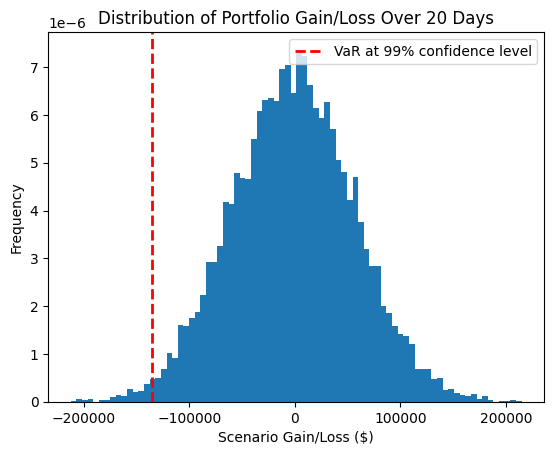

In [14]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=80, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()